In [1]:
import cv2

In [38]:
video = cv2.VideoCapture("./video_processing/test_files/test_video_240608_170343.mp4")

In [39]:
from video_processing.utils import get_fps, get_num_frames, get_width, get_height

print(get_fps(video))
print(get_num_frames(video))
print(get_width(video))
print(get_height(video))

video_len = get_num_frames(video) / get_fps(video)
print(video_len)

120
2996
1920
1080
24.966666666666665


In [40]:
from tqdm import tqdm_notebook

In [41]:
video_frames = []
for i in tqdm_notebook(range(get_num_frames(video))):
    success, frame = video.read()
    video_frames.append(frame)

/var/folders/7h/7r4qms6j40sc8f7hnfp0qg_80000gn/T/ipykernel_75915/999950574.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(get_num_frames(video))):


  0%|          | 0/2996 [00:00<?, ?it/s]

In [42]:
video_frames[0].shape

(1080, 1920, 3)

In [43]:
import numpy as np

timestamp = np.random.uniform(0, video_len)
index = int(round(timestamp * get_fps(video)))
print(index)




2235


In [44]:
from video_processing.utils import crop_and_resize, detect_edge, sharpen_edges

In [45]:
# preprocess - crop and sharpen edges
preprocessed_frames = []
for frame in tqdm_notebook(video_frames):
    x_min, x_max, y_min, y_max = detect_edge(frame)
    frame_ = sharpen_edges(crop_and_resize(frame, x_min, x_max, y_min, y_max))
    preprocessed_frames.append(frame_)

/var/folders/7h/7r4qms6j40sc8f7hnfp0qg_80000gn/T/ipykernel_75915/3447392534.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for frame in tqdm_notebook(video_frames):


  0%|          | 0/2996 [00:00<?, ?it/s]

In [46]:
preprocessed_frames[1000].mean()

1.3095558449074074

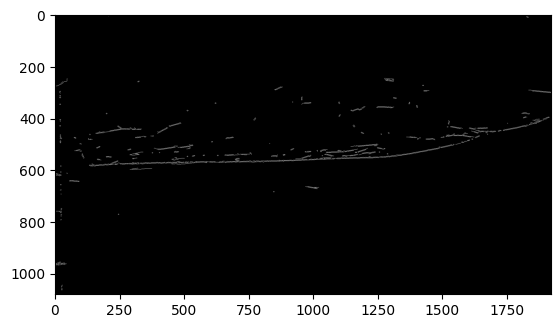

In [47]:
from matplotlib import pyplot as plt

# gray = cv2.cvtColor(preprocessed_frames[100], cv2.COLOR_BGR2GRAY)
plt.imshow(255 - preprocessed_frames[1002], cmap='gray_r')


In [50]:
# resulting array's shape
# proportions should match with real box size
# arr_width = 400
# arr_height = 300
# arr_depth = 400
arr_width = 100
arr_height = 75
arr_depth = 100

resized_preprocessed_frames = [None] * len(preprocessed_frames)
for i, frame in tqdm_notebook(enumerate(preprocessed_frames)):
    resized_preprocessed_frames[i] = np.array(cv2.resize(frame, (arr_width, arr_height)) / 255, dtype=bool)



/var/folders/7h/7r4qms6j40sc8f7hnfp0qg_80000gn/T/ipykernel_75915/2444843114.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, frame in tqdm_notebook(enumerate(preprocessed_frames)):


0it [00:00, ?it/s]

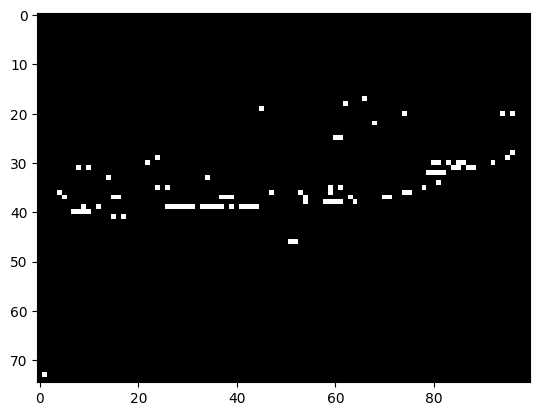

In [105]:
plt.imshow(255 - resized_preprocessed_frames[1001], cmap='gray_r')

In [90]:
np.sum(resized_preprocessed_frames[1000])

81

In [52]:
frames_arr = np.stack(resized_preprocessed_frames, axis=0)
print(frames_arr.shape)

(2996, 75, 100)


In [102]:


arr = np.zeros((arr_depth, arr_height, arr_width), dtype=bool)

total_num_frames = get_num_frames(video)


def is_point_on_section(video_frames_arr: np.ndarray, d_idx: int, h_idx: int, w_idx: int) -> bool:
    num_close_frames = 30  # number of frames to see
    nbh_thres = 3  # number of neighborhood pixels to check (L^inf distance)
    on_frame_thres = 0.1  # threshold to determine whether the point is on the frame or not
    on_section_frame_num_thres = 5

    frame_index = int(round((d_idx / arr_depth) * total_num_frames))
    fidx_s = max(frame_index - (num_close_frames - 1) // 2, 0)
    hidx_s = max(h_idx - nbh_thres, 0)
    widx_s = max(w_idx - nbh_thres, 0)
    nbh = video_frames_arr[fidx_s: frame_index + (num_close_frames + 1) // 2, hidx_s: h_idx + nbh_thres + 1, widx_s: w_idx + nbh_thres + 1]
    on_frame_ratios = np.sum(nbh, axis=(1, 2)) / (nbh.shape[1] * nbh.shape[2])
    on_frame = on_frame_ratios > on_frame_thres
    return np.sum(on_frame) >= on_section_frame_num_thres



def video_to_array(video_frames_arr: np.ndarray, arr_width: int, arr_height: int, arr_depth: int):
    arr = np.zeros((arr_depth, arr_height, arr_width))
    x_indices = []  # depth
    y_indices = []  # width
    z_indices = []  # height
    for d_idx in tqdm_notebook(range(arr_depth)):
        for h_idx in range(arr_height):
            for w_idx in range(arr_width):
                if is_point_on_section(video_frames_arr, d_idx, h_idx, w_idx):
                    arr[d_idx, h_idx, w_idx] = True
                    x_indices.append(d_idx)
                    y_indices.append(w_idx)
                    z_indices.append(h_idx)
    return arr, x_indices, y_indices, z_indices


In [103]:
video_arr, xs, ys, zs = video_to_array(frames_arr, arr_width, arr_height, arr_depth)
assert video_arr.shape == (arr_depth, arr_height, arr_width)

/var/folders/7h/7r4qms6j40sc8f7hnfp0qg_80000gn/T/ipykernel_75915/3325130045.py:28: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/100 [00:00<?, ?it/s]

In [104]:
import plotly.express as px

fig = px.scatter_3d(x=xs, y=ys, z=zs)
fig.update_traces(marker_size=1)
fig.show() 



# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.voxels(video_arr)

# plt.show()

In [106]:
import open3d as o3d

pcd = o3d.io.read_point_cloud("./ex.pcd")
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


2024-06-22 19:12:29.935 Python[75915:2461432] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
